#  Прогнозирование заказов такси

Цель проекта: построить модель прогноза количества заказов такси на следующий час.
Заказчик: «Чётенькое такси»

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Задачи:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


## Подготовка

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, make_scorer
import warnings


In [2]:
#Грузим данные с установкой даты в качестве индексов
df = pd.read_csv('Ya_data/taxi.csv', index_col=[0], parse_dates=[0])
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Количество заказов находится в столбце `num_orders`. Данные обновляются каждые 10 мин.

In [3]:
#Проверим хронологический порядок дат
df.index.is_monotonic

True

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
#Ресемплируем данные по часу
df = df.resample('1H').sum()
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


Данные загружены, проверены и ресемплированы.

## Анализ

Text(0.5, 1.0, 'Скользящее среднее с усреднением за 24 часа')

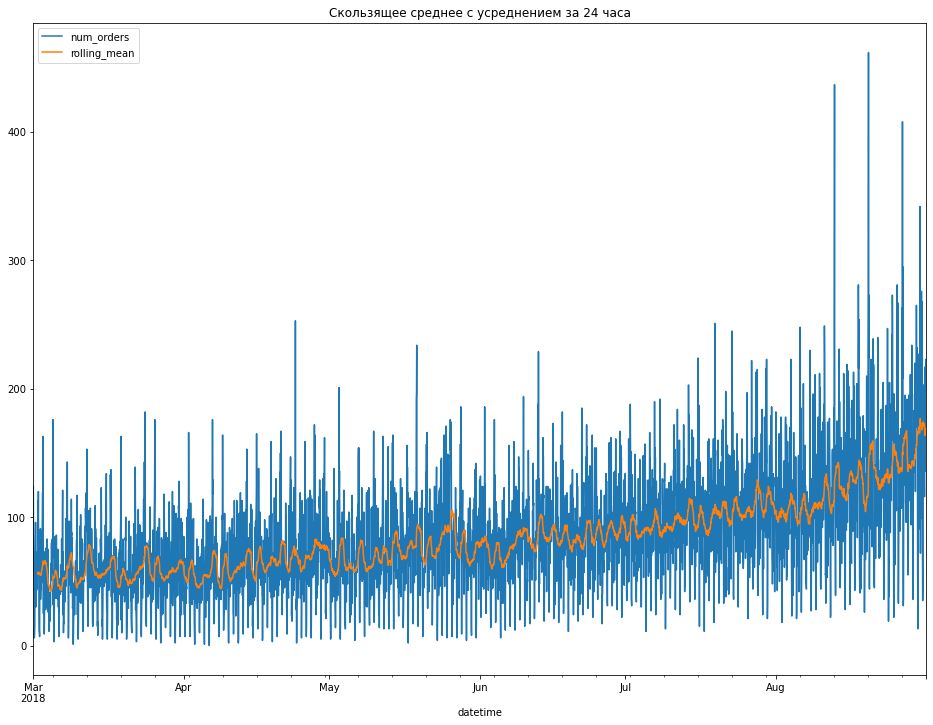

In [6]:
# Строим график скользящего среднего 
df['rolling_mean'] = df.rolling(24).mean()
df.plot(figsize = (16,12))
plt.title('Скользящее среднее с усреднением за 24 часа')

Рассмотрим тренды и сезонность

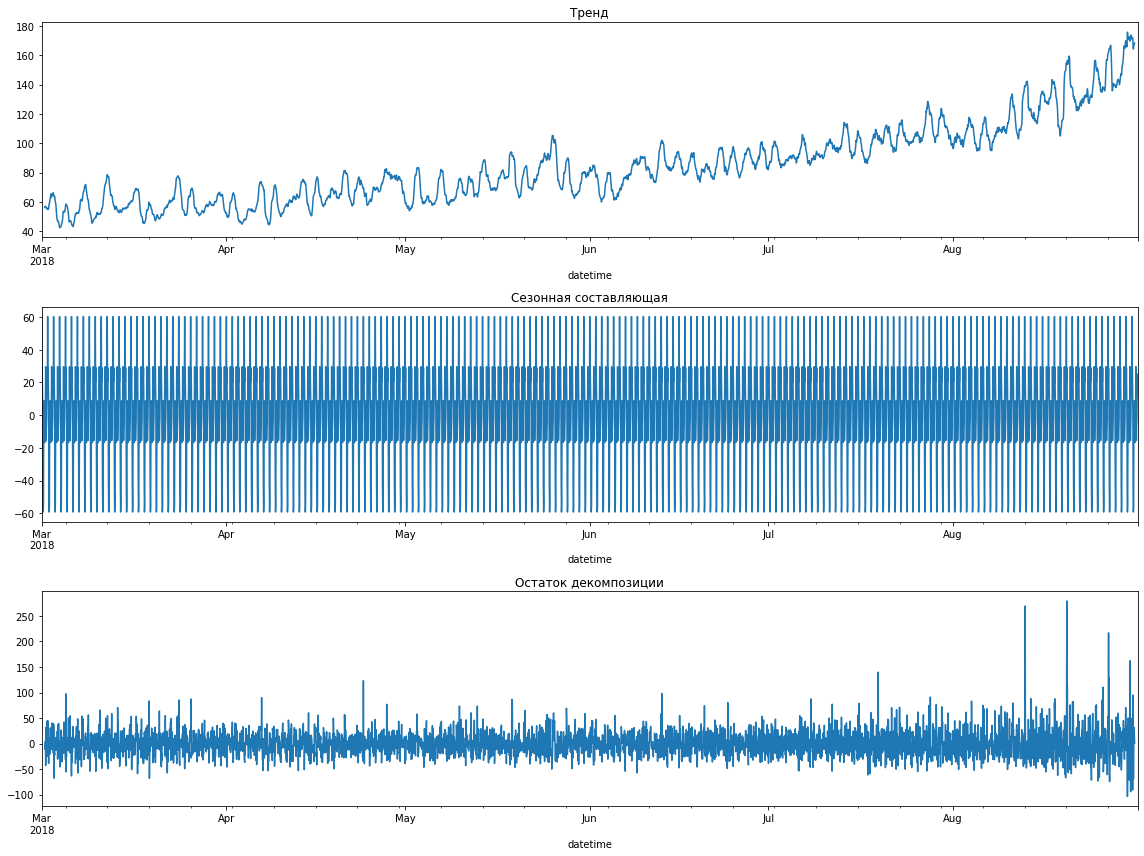

In [7]:

decomposed = seasonal_decompose(df.num_orders)
plt.figure(figsize=(16, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Сезонная составляющая')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток декомпозиции')
plt.tight_layout()

Посмотрим сезонность в течении суток.

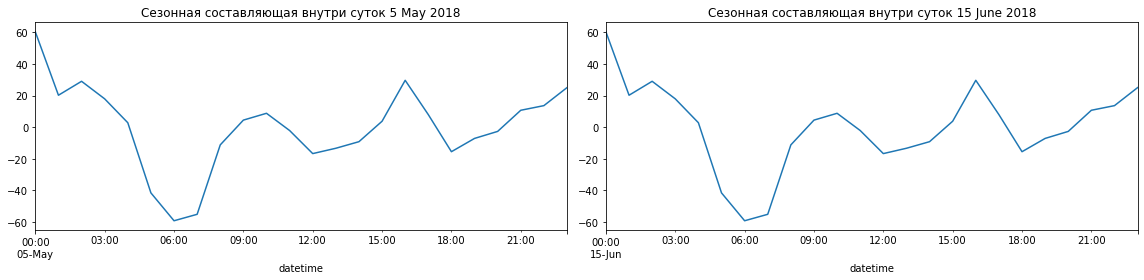

In [8]:
plt.figure(figsize=(16, 4))
plt.subplot(121)
decomposed.seasonal['5 May 2018'].plot(ax=plt.gca())
plt.title('Сезонная составляющая внутри суток 5 May 2018')
plt.subplot(122)
decomposed.seasonal['15 June 2018'].plot(ax=plt.gca())
plt.title('Сезонная составляющая внутри суток 15 June 2018')
plt.tight_layout()

По графикам можно выделить восходящий тренд и сезонную составляющую внутри любого дня.

## Обучение

In [9]:
#Создаем признаки для обучения: календарные, отстающие и скользящее среднее
def make_features(data, max_lag, rolling_mean_size):
    data_new = data.copy()
    data_new['month'] = data.index.month
    data_new['day'] = data.index.day
    data_new['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)

    data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_new

In [10]:
#Делаем RMSE из MSE
def RMSE_score(y_true, y_pred):
    RMSE = mean_squared_error(y_true, y_pred) ** 0.5
    return RMSE

RMSE_scorer = make_scorer(RMSE_score, greater_is_better=False)

Оценки RMSE для 12 отстающих признаков: [29.17868246 30.27932828 36.85183507]
Средняя оценка RMSE: 32.10328193578388
________________________________
Оценки RMSE для 24 отстающих признаков: [24.95827434 25.79918181 31.8202184 ]
Средняя оценка RMSE: 27.5258915136985
________________________________
Оценки RMSE для 36 отстающих признаков: [25.52828547 25.46785159 32.13352161]
Средняя оценка RMSE: 27.709886222524478
________________________________
Оценки RMSE для 48 отстающих признаков: [22.46683559 23.57177808 29.5506779 ]
Средняя оценка RMSE: 25.19643052518796
________________________________
Оценки RMSE для 60 отстающих признаков: [23.07045134 23.56725056 29.84503983]
Средняя оценка RMSE: 25.49424724426349
________________________________
Оценки RMSE для 72 отстающих признаков: [22.57043327 23.02394037 28.97884444]
Средняя оценка RMSE: 24.857739358352962
________________________________
Оценки RMSE для 84 отстающих признаков: [22.59465329 22.95002163 29.24183296]
Средняя оценка RMSE: 

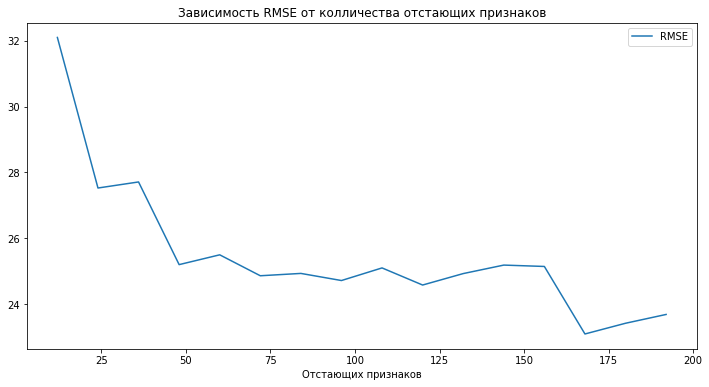

In [11]:
# Подбираем колличество отстающих признаков
df_L = df.copy()
best_RMSE = -1000
lags_scores = []
for lag in range(12,200,12):
    warnings.filterwarnings("ignore")
    df_mfl = make_features(df_L, lag, 24)
    train_mfl, test_mfl = train_test_split(df_mfl, shuffle=False, test_size=0.1)
    train_mfl = train_mfl.dropna()
    train_target_mfl = train_mfl['num_orders']
    train_features_mfl = train_mfl.drop('num_orders', axis = 1)
    scores = cross_val_score(LinearRegression(), 
                             train_features_mfl, 
                             train_target_mfl, 
                             scoring = RMSE_scorer, 
                             cv=TimeSeriesSplit(n_splits=3))
    print ('Оценки RMSE для',lag, 'отстающих признаков:', abs(scores))
    final_score = scores.mean()
    print('Средняя оценка RMSE:', abs(final_score))
    print("________________________________")
    lags_scores.append([lag, abs(final_score)])
    
    if final_score > best_RMSE:
        best_RMSE = round(final_score,2)
        best_lag = lag

print("Лучшая RMSE:", abs(best_RMSE), "Отстающих признаков:", best_lag)
pd.DataFrame(lags_scores, columns = ['Отстающих признаков', 'RMSE']).plot(x='Отстающих признаков', figsize=(12, 6))
plt.title('Зависимость RMSE от колличества отстающих признаков')
plt.show()

Чем больше признаков, тем точнее предсказания. После 48 отстающих признаков RMSE не сильно улучшается. Чтобы не перегружать модель остановимся на 24 признаках.

In [12]:
df = make_features(df, 24, 24)
# Делим данные на тренировочную и тестовую и удаляем пропуски 
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

In [13]:
train_target = train['num_orders']
train_features = train.drop('num_orders', axis = 1)

Учим линейную регрессию

In [14]:
%%time
model_LR = LinearRegression()
model_LR.fit(train_features, train_target)
train_pred_LR = model_LR.predict(train_features)
print("RMSE обучающей выборки для LinearRegression:", RMSE_score(train_target, train_pred_LR))

RMSE обучающей выборки для LinearRegression: 25.821357138492868
Wall time: 5.79 ms


Учим случейный лес. Для подбора гиперпараметров параметров используем GridsearchCV с TimeSeriesSplit всесто кросвалидации.

In [15]:
%%time
parametrs_RFR = { 'n_estimators': range (5,15,5),
                  'max_depth': range (10,25,2),
                  'min_samples_leaf': range (2,4,1),
                  'min_samples_split': range (2,4,1) }

model_RFR = RandomForestRegressor(random_state=123)
tscv = TimeSeriesSplit(n_splits=3)
model_RFR = GridSearchCV(model_RFR, parametrs_RFR, scoring=RMSE_scorer, cv=tscv, n_jobs=-1)
model_RFR.fit(train_features, train_target)
print("Лучшие параметры для RandomForestRegressor:", model_RFR.best_params_)
print('Лучшая оценка RMSE для RandomForestRegressor:',  abs(model_RFR.best_score_))

Лучшие параметры для RandomForestRegressor: {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 10}
Лучшая оценка RMSE для RandomForestRegressor: 28.38567754973432
Wall time: 5.68 s


## Тестирование

In [16]:
# Считаем метрики на тестовых выборках
test_target = test['num_orders']
test_features = test.drop('num_orders', axis = 1)

test_pred_LR = model_LR.predict(test_features)
print("RMSE тестовой выборки для LinearRegression: ", RMSE_score(test_target, test_pred_LR))

test_pred_RFR = model_RFR.best_estimator_.predict(test_features)
print("RMSE тестовой выборки для RandomForestRegressor: ", RMSE_score(test_target, test_pred_RFR))

RMSE тестовой выборки для LinearRegression:  45.50510292609076
RMSE тестовой выборки для RandomForestRegressor:  45.47770412901422


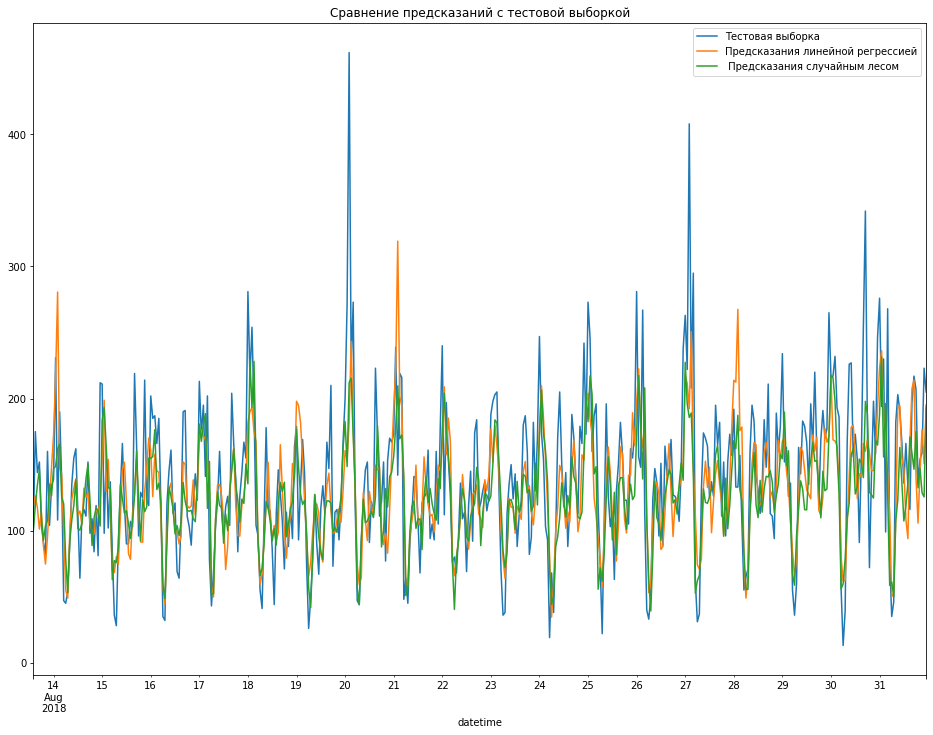

In [17]:
orders = pd.DataFrame(test_target)
orders['pred_LR']=test_pred_LR
orders['pred_RFR']=test_pred_RFR
orders.plot(figsize=(16, 12))
plt.title('Сравнение предсказаний с тестовой выборкой')
plt.legend(['Тестовая выборка', 'Предсказания линейной регрессией', ' Предсказания случайным лесом'])
plt.show()

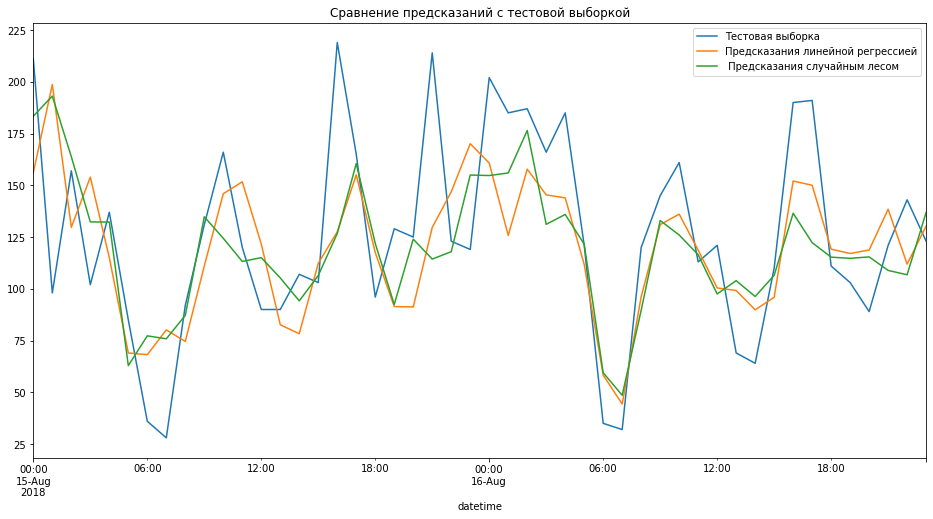

In [18]:
orders['15 Aug 2018' : '16 Aug 2018'].plot(figsize=(16, 8))
plt.title('Сравнение предсказаний с тестовой выборкой')
plt.legend(['Тестовая выборка', 'Предсказания линейной регрессией', ' Предсказания случайным лесом'])
plt.show()

## Вывод


Анализ временного ряда выявил восходящий тренд и сезонность в течении суток. Качество модели зависит от количества отложенных признаков. Чем больше, там точнее предсказания. Линейная регрессия показывает немногим лучший результат чем случайный лес с подбором гиперапраметров. На тестовой выборке метрика RMSE для обоих моделей значительно хуже чем на тренировочной.  Возможно это связвно с возрастающим трендом. Обе модели выдают одинаковый результат. Для сохранения точности с течением времени модель нужно переобучать. Линейная регрессия учится быстрее, поэтому рекомендуется использолвать ее.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48